In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import cooler
import cooltools.lib.plotting
from cooltools import insulation

from packaging import version
if version.parse(cooltools.__version__) < version.parse('0.5.2'):
    raise AssertionError("tutorials rely on cooltools version 0.5.2 or higher,"+
                         "please check your cooltools version and update to the latest")



In [3]:
!pwd

/Users/renhaoluo/Desktop/Harvard_Master/2022_Fall/HST.508/final_project/HST508_Fall2022_final_project/codes


In [3]:
import cooltools
data_dir = '../data/'
# cool_file = cooltools.download_data("HFF_MicroC", cache=True, data_dir=data_dir)
cool_file = data_dir + "4DNFITHTURR9.mcool"
print(cool_file)

../data/4DNFITHTURR9.mcool


In [5]:
resolution = 10000
clr = cooler.Cooler(f'{data_dir}4DNFITHTURR9.mcool::resolutions/{resolution}')
windows = [3*resolution, 5*resolution, 10*resolution, 25*resolution]
insulation_table = insulation(clr, windows, verbose=True)

INFO:root:Processing region chr1
INFO:root:Processing region chr2
INFO:root:Processing region chr3
INFO:root:Processing region chr4
INFO:root:Processing region chr5
INFO:root:Processing region chr6
INFO:root:Processing region chr7
INFO:root:Processing region chr8
INFO:root:Processing region chr9
INFO:root:Processing region chr10
INFO:root:Processing region chr11
INFO:root:Processing region chr12
INFO:root:Processing region chr13
INFO:root:Processing region chr14
INFO:root:Processing region chr15
INFO:root:Processing region chr16
INFO:root:Processing region chr17
INFO:root:Processing region chr18
INFO:root:Processing region chr19
INFO:root:Processing region chrX
INFO:root:Processing region chrY


In [6]:
first_window_summary =insulation_table.columns[[ str(windows[-1]) in i for i in insulation_table.columns]]

insulation_table[['chrom','start','end','region','is_bad_bin']+list(first_window_summary)].iloc[1000:1005]

,chrom,start,end,region,is_bad_bin,log2_insulation_score_250000,n_valid_pixels_250000,boundary_strength_250000,is_boundary_250000
1000,chr1,10000000,10010000,chr1,False,0.250673,622.0,NaN,False
1001,chr1,10010000,10020000,chr1,False,0.213238,622.0,NaN,False
1002,chr1,10020000,10030000,chr1,False,0.161346,622.0,NaN,False
1003,chr1,10030000,10040000,chr1,False,0.114869,622.0,NaN,False
1004,chr1,10040000,10050000,chr1,False,0.065562,622.0,NaN,False


In [7]:
# Functions to help with plotting
def pcolormesh_45deg(ax, matrix_c, start=0, resolution=1, *args, **kwargs):
    start_pos_vector = [start+resolution*i for i in range(len(matrix_c)+1)]
    import itertools
    n = matrix_c.shape[0]
    t = np.array([[1, 0.5], [-1, 0.5]])
    matrix_a = np.dot(np.array([(i[1], i[0])
                                for i in itertools.product(start_pos_vector[::-1],
                                                           start_pos_vector)]), t)
    x = matrix_a[:, 1].reshape(n + 1, n + 1)
    y = matrix_a[:, 0].reshape(n + 1, n + 1)
    im = ax.pcolormesh(x, y, np.flipud(matrix_c), *args, **kwargs)
    im.set_rasterized(True)
    return im

from matplotlib.ticker import EngFormatter
bp_formatter = EngFormatter('b')
def format_ticks(ax, x=True, y=True, rotate=True):
    if y:
        ax.yaxis.set_major_formatter(bp_formatter)
    if x:
        ax.xaxis.set_major_formatter(bp_formatter)
        ax.xaxis.tick_bottom()
    if rotate:
        ax.tick_params(axis='x',rotation=45)

Text(0.5, 0.98, 'Chr2 TADs boundary (mouse ES)')

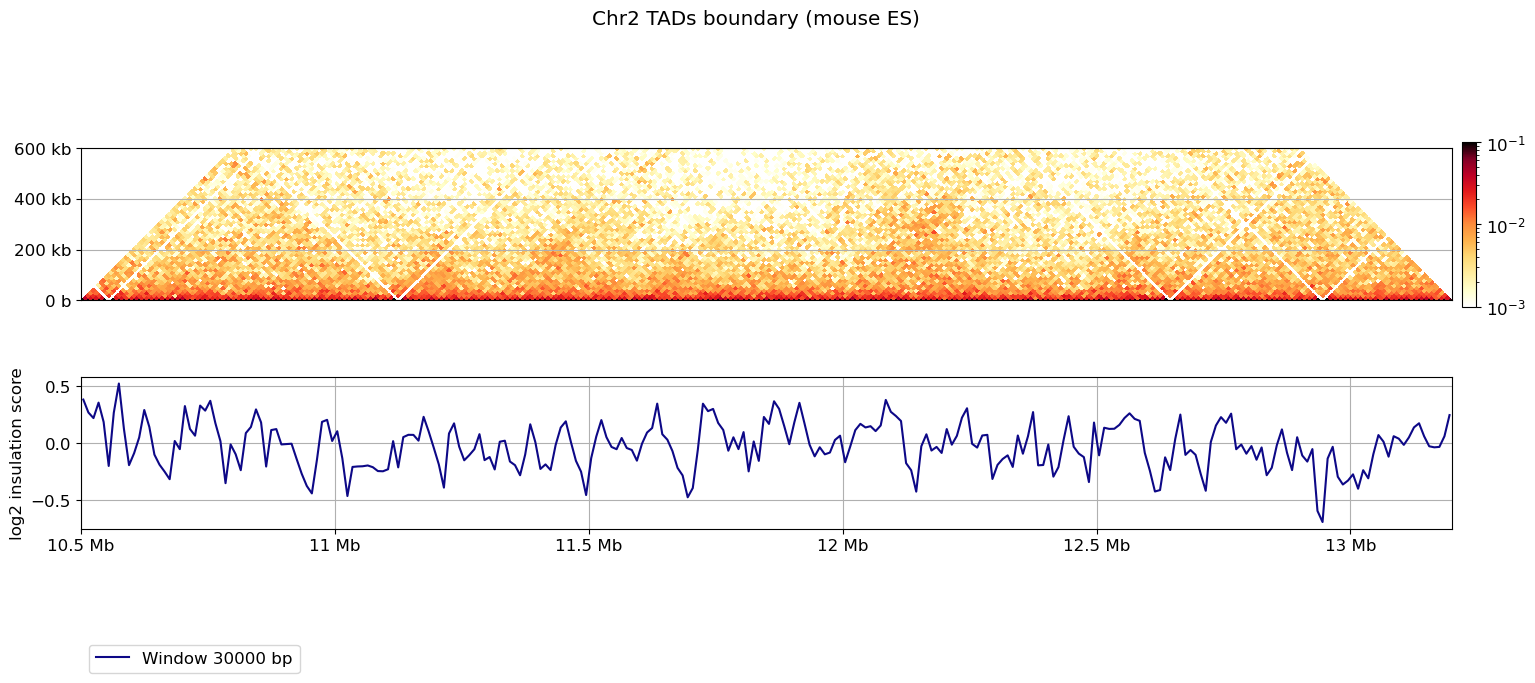

In [19]:
from matplotlib.colors import LogNorm
from mpl_toolkits.axes_grid1 import make_axes_locatable
import bioframe
plt.rcParams['font.size'] = 12

start = 10_500_000
end = start+ 90*windows[0]
region = ('chr2', start, end)
norm = LogNorm(vmax=0.1, vmin=0.001)
data = clr.matrix(balance=True).fetch(region)
f, ax = plt.subplots(figsize=(18, 6))
im = pcolormesh_45deg(ax, data, start=region[1], resolution=resolution, norm=norm, cmap='fall')
ax.set_aspect(0.5)
ax.set_ylim(0, 20*windows[0]) # adjust y
format_ticks(ax, rotate=False)
ax.xaxis.set_visible(False)

divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="1%", pad=0.1, aspect=6)
plt.colorbar(im, cax=cax)

insul_region = bioframe.select(insulation_table, region)

ins_ax = divider.append_axes("bottom", size="50%", pad=0., sharex=ax)
ins_ax.set_prop_cycle(plt.cycler("color", plt.cm.plasma(np.linspace(0,1,5))))
ins_ax.plot(insul_region[['start', 'end']].mean(axis=1),
            insul_region['log2_insulation_score_'+str(windows[0])],
            label=f'Window {windows[0]} bp')
ins_ax.grid()
ins_ax.set_ylabel("log2 insulation score")

ins_ax.legend(bbox_to_anchor=(0., -1), loc='lower left', ncol=4);

format_ticks(ins_ax, y=False, rotate=False)
ax.set_xlim(region[1], region[2])
ax.grid()
f.suptitle("Chr2 TADs boundary (mouse ES)");

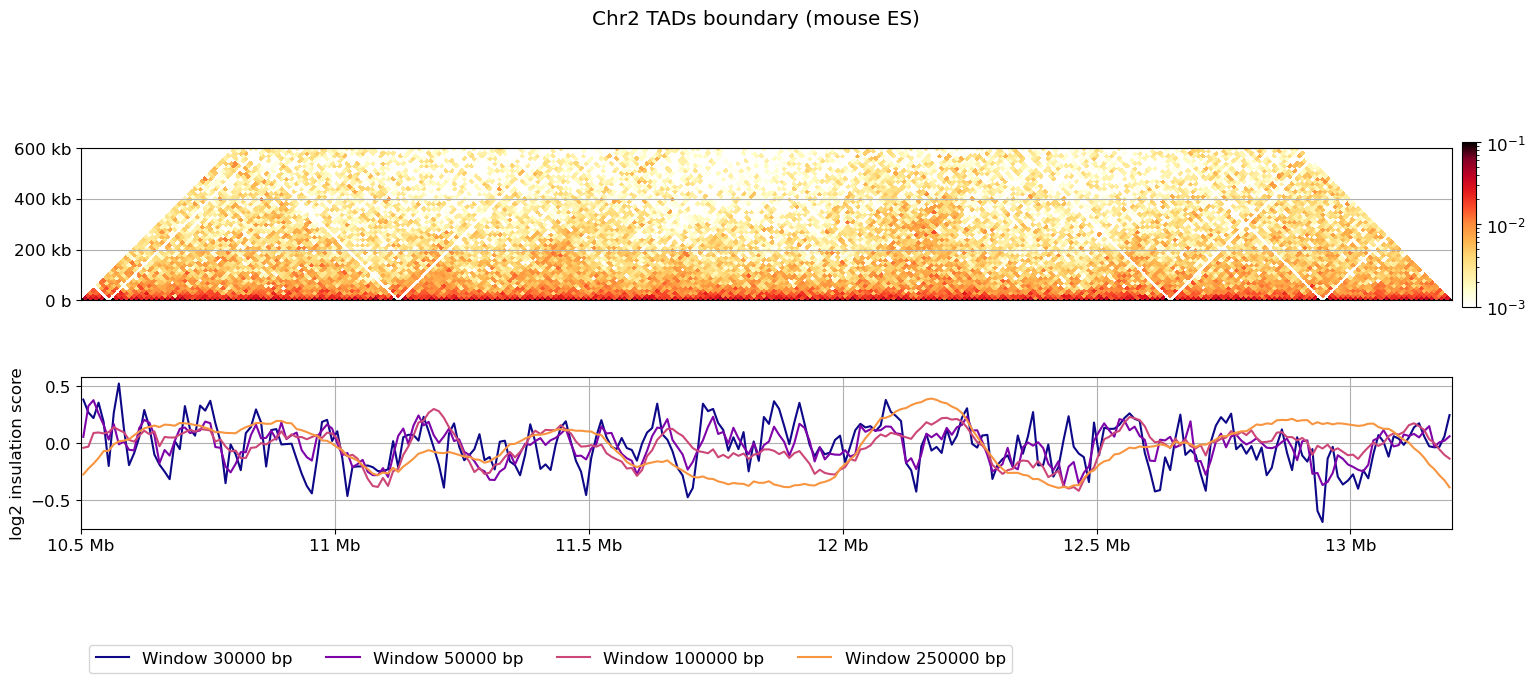

In [20]:
for res in windows[1:]:
    ins_ax.plot(insul_region[['start', 'end']].mean(axis=1), insul_region[f'log2_insulation_score_{res}'], label=f'Window {res} bp')
ins_ax.legend(bbox_to_anchor=(0., -1), loc='lower left', ncol=4);


In [25]:
font = {'family' : 'normal',
        'size'   : 18}

plt.rc('font', **font)

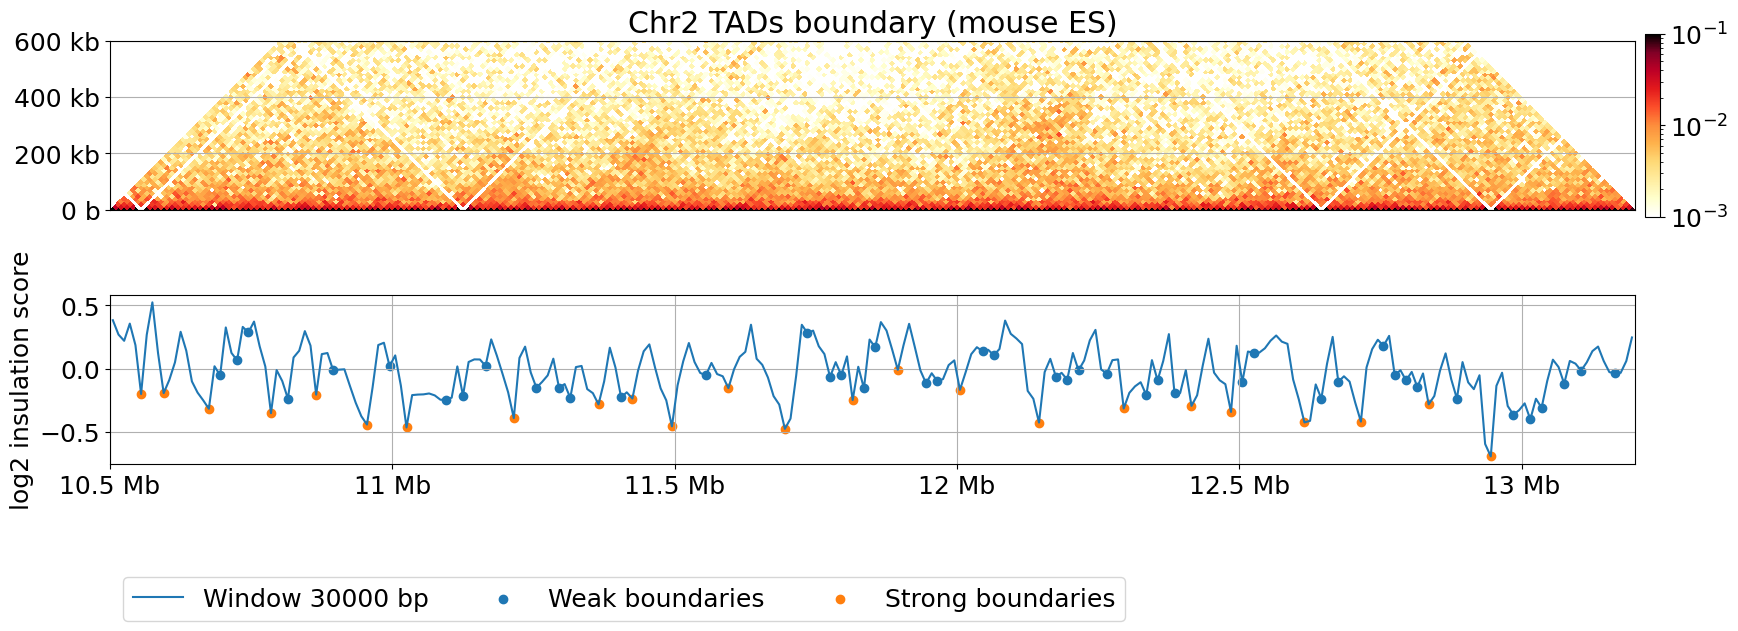

In [26]:
f, ax = plt.subplots(figsize=(20, 10))
im = pcolormesh_45deg(ax, data, start=region[1], resolution=resolution, norm=norm, cmap='fall')
ax.set_aspect(0.5)
ax.set_ylim(0, 20*windows[0])
format_ticks(ax, rotate=False)
ax.xaxis.set_visible(False)

divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="1%", pad=0.1, aspect=6)
plt.colorbar(im, cax=cax)

insul_region = bioframe.select(insulation_table, region)

ins_ax = divider.append_axes("bottom", size="50%", pad=0., sharex=ax)

ins_ax.plot(insul_region[['start', 'end']].mean(axis=1),
            insul_region[f'log2_insulation_score_{windows[0]}'], label=f'Window {windows[0]} bp')

boundaries = insul_region[~np.isnan(insul_region[f'boundary_strength_{windows[0]}'])]
weak_boundaries = boundaries[~boundaries[f'is_boundary_{windows[0]}']]
strong_boundaries = boundaries[boundaries[f'is_boundary_{windows[0]}']]
ins_ax.scatter(weak_boundaries[['start', 'end']].mean(axis=1),
            weak_boundaries[f'log2_insulation_score_{windows[0]}'], label='Weak boundaries')
ins_ax.scatter(strong_boundaries[['start', 'end']].mean(axis=1),
            strong_boundaries[f'log2_insulation_score_{windows[0]}'], label='Strong boundaries')

ins_ax.legend(bbox_to_anchor=(0., -1), loc='lower left', ncol=4);
ins_ax.grid()
ins_ax.set_ylabel("log2 insulation score")

format_ticks(ins_ax, y=False, rotate=False)
ax.set_xlim(region[1], region[2])

ax.grid()
ax.set_title("Chr2 TADs boundary (mouse ES)");

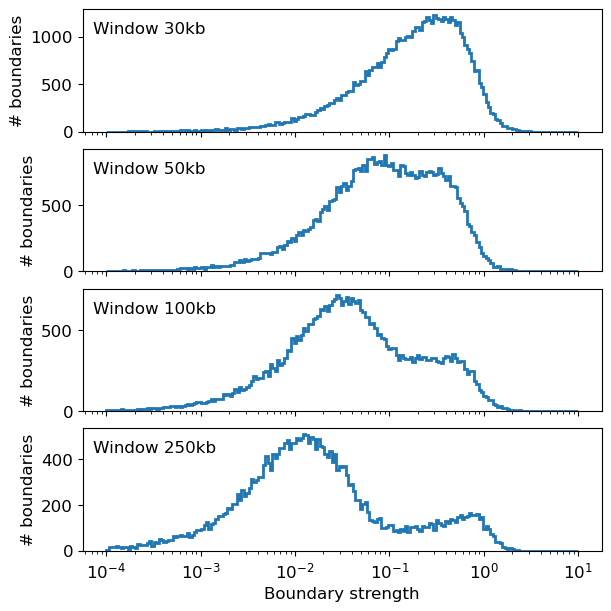

In [11]:
histkwargs = dict(
    bins=10**np.linspace(-4,1,200),
    histtype='step',
    lw=2,
)

f, axs = plt.subplots(len(windows),1, sharex=True, figsize=(6,6), constrained_layout=True)
for i, (w, ax) in enumerate(zip(windows, axs)):
    ax.hist(
        insulation_table[f'boundary_strength_{w}'],
        **histkwargs
    )
    ax.text(0.02, 0.9,
             f'Window {w//1000}kb',
             ha='left',
             va='top',
             transform=ax.transAxes)

    ax.set(
        xscale='log',
        ylabel='# boundaries'
    )

axs[-1].set(xlabel='Boundary strength');

[Text(0.5, 0, 'Boundary strength')]

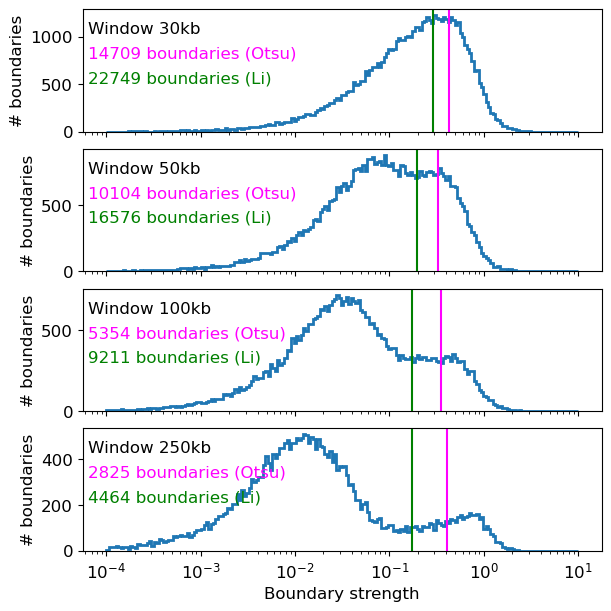

In [12]:
from skimage.filters import threshold_li, threshold_otsu

f, axs = plt.subplots(len(windows), 1, sharex=True, figsize=(6,6), constrained_layout=True)
thresholds_li = {}
thresholds_otsu = {}
for i, (w, ax) in enumerate(zip(windows, axs)):
    ax.hist(
        insulation_table[f'boundary_strength_{w}'],
        **histkwargs
    )
    thresholds_li[w] = threshold_li(insulation_table[f'boundary_strength_{w}'].dropna().values)
    thresholds_otsu[w] = threshold_otsu(insulation_table[f'boundary_strength_{w}'].dropna().values)
    n_boundaries_li = (insulation_table[f'boundary_strength_{w}'].dropna()>=thresholds_li[w]).sum()
    n_boundaries_otsu = (insulation_table[f'boundary_strength_{w}'].dropna()>=thresholds_otsu[w]).sum()
    ax.axvline(thresholds_li[w], c='green')
    ax.axvline(thresholds_otsu[w], c='magenta')
    ax.text(0.01, 0.9,
             f'Window {w//1000}kb',
             ha='left',
             va='top',
             transform=ax.transAxes)
    ax.text(0.01, 0.7,
            f'{n_boundaries_otsu} boundaries (Otsu)',
            c='magenta',
            ha='left',
            va='top',
            transform=ax.transAxes)
    ax.text(0.01, 0.5,
            f'{n_boundaries_li} boundaries (Li)',
            c='green',
            ha='left',
            va='top',
            transform=ax.transAxes)

    ax.set(
        xscale='log',
        ylabel='# boundaries'
    )

axs[-1].set(xlabel='Boundary strength')